### Stock Price Prediction (Simple Regression)

The yfinance will be the dataset for this machine learning model

In [78]:
import yfinance as yf

Will we also need the following libraries for the model

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Fetch historical stock data from Apple - "AAPL"

Download dataset and drop the null values (from the original dataset)

In [80]:
stock_symbol = "AAPL"
df = yf.download(stock_symbol, start="2020-01-01", end="2025-01-01")
df = df[["Close"]]
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


We create the target variable by shifting the closing price column one row up (shift(-1)).


This aligns today’s closing price (X) with tomorrow’s closing price (y), making it a supervised learning problem.


The last row will have a missing value since there’s no future price available, so we remove it to keep the data clean.

In [81]:
df["Tomorrow"] = df["Close"].shift(-1)
df.dropna(inplace=True)

X = df[['Close']].values  # Features
y = df['Tomorrow'].values  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Train a Linear Regression Model

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Evaluate & Visualize

Check model performance

In [35]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")

MAE: 2.1667, MSE: 8.5242


### MAE and MSE Explanation

**MAE** (Mean Absolute Error) measures the average magnitude of errors in predictions, showing how far the predicted values are from the actual ones.  
**MSE** (Mean Squared Error) calculates the average of squared differences, penalizing larger errors more.


For my model, the MAE is 2.17, meaning the predictions are off by around 2.17 dollars on average. For a stock price of 105 dollars, this means predictions are usually within +-2.17 dollars.


The MSE is 8.52, suggesting some larger errors in the predictions.

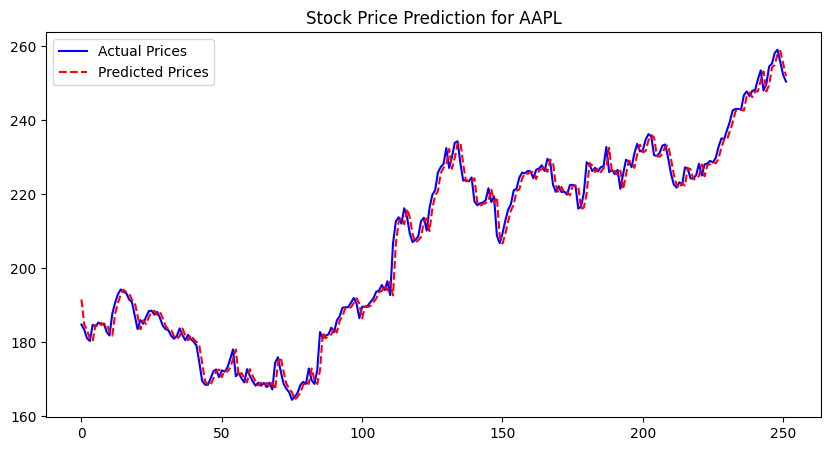

In [37]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", linestyle='dashed', color='red')
plt.legend()
plt.title(f"Stock Price Prediction for {stock_symbol}")
plt.show()

This plot compares the actual and predicted stock prices, with actual prices in blue and predicted prices in red (dashed).

### Enhancing Model - Additional Features

- Moving Averages
- The Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)

### Moving Averages

In [82]:
# Simple Moving Average (SMA)
df["SMA_20"] = df["Close"].rolling(window=20).mean()

# Exponential Moving Average (EMA)
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

### The Relative Strength Index (RSI)



In [83]:
import numpy as np

delta = df["Close"].diff() #daily price change

gain = delta.where(delta > 0, 0) #if delta > 0 -> gain else 0
loss = delta.where(delta < 0, 0) #if delta < 0 -> loss else 0

average_gain = gain.rolling(window=14).mean()
average_loss = gain.rolling(window=14).mean()

rs = average_gain / average_loss

df["RSI"] = 100 - (100 / (1 + rs))

In [84]:
print(df["RSI"].head())

Date
2020-01-02   NaN
2020-01-03   NaN
2020-01-06   NaN
2020-01-07   NaN
2020-01-08   NaN
Name: RSI, dtype: float64


### Moving Average Convergence Divergence (MACD)

In [85]:
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean() # Short-term EMA
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean() # Logn-term EMA

df["MACD"] = df["EMA_12"] - df["EMA_26"]

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean() # Signal Line (9-day EMA of MACD)

Now that we have multiple new features we can use them to train the model

In [100]:
df.columns = df.columns.get_level_values('Price')
df = df.dropna(subset=["Close", 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', "Tomorrow"])

# Define features (X) and target (y)
X = df[["Close", 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal']].values
y = df["Tomorrow"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [98]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [99]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")

MAE: 2.1908, MSE: 8.5525


The extra features did not make the model better, they made it slightly worse